In [10]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import io

# Zadanie

Dysponujesz danymi z portalu Our World in Data dotyczącymi:
- Pierwotnej konsumpcji energii
- Emisji CO2 z poszczególnych lat dla różnych krajów

## Część 1: Plik CSV
Utwórz plik CSV zawierający połączone dane dla Polski:
- konsumpcja energii pierwotnej
- emisja CO2
- dane z poszczególnych lat

## Część 2: Plik Excel
Stwórz plik Excel z osobnymi zakładkami dla każdego kraju:
- UE
- USA
- Chiny
- Indie

Każda zakładka powinna zawierać dane o konsumpcji energii i emisji CO2.

## Część 3: Baza danych SQLite
Utwórz bazę danych SQLite z tabelą zawierającą:
- kraj
- rok
- emisja CO2
- konsumpcja energii

Dane powinny obejmować: Polskę, Niemcy i Hiszpanię.

## Część 4: Analiza i wizualizacja
Na podstawie danych z pliku Excel i bazy SQLite utwórz wykresy:
- emisja CO2 w zależności od roku (dla wybranego kraju)
- konsumpcja energii pierwotnej w zależności od roku (dla wybranego kraju)
- **dla chęnych szukanie koreacji**

In [11]:
df_co2 = pd.read_csv("/content/co2-emissions-per-capita.csv")
df_co2.head()

,Entity,Year,Annual CO₂ emissions (per capita)
0,Afghanistan,1949,0.001992
1,Afghanistan,1950,0.010837
2,Afghanistan,1951,0.011625
3,Afghanistan,1952,0.011468
4,Afghanistan,1953,0.013123


In [12]:
df_primary_energy = pd.read_csv("/content/primary-energy-cons.csv")
df_primary_energy.head()

,Entity,Code,Year,Primary energy consumption (TWh)
0,Afghanistan,AFG,1980,6.337187
1,Afghanistan,AFG,1981,7.289555
2,Afghanistan,AFG,1982,7.889244
3,Afghanistan,AFG,1983,9.882159
4,Afghanistan,AFG,1984,9.929878


In [13]:
energy_pl = df_primary_energy[df_primary_energy['Entity'] == 'Poland']
co2_pl = df_co2[df_co2['Entity'] == 'Poland']

energy_pl = energy_pl[['Entity', 'Year', 'Primary energy consumption (TWh)']]
co2_pl = co2_pl[['Entity', 'Year', 'Annual CO₂ emissions (per capita)']]

merged = pd.merge(energy_pl, co2_pl, on=['Year', 'Entity'], how='outer')

merged = merged.sort_values(by="Year")
merged.to_csv("poland_energy_co2.csv", index=False)
merged.head()

,Entity,Year,Primary energy consumption (TWh),Annual CO₂ emissions (per capita)
0,Poland,1800,NaN,0.045189
1,Poland,1801,NaN,0.048900
2,Poland,1802,NaN,0.049344
3,Poland,1803,NaN,0.050177
4,Poland,1804,NaN,0.049414


In [14]:
!pip install xlsxwriter

eu_countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia",
    "Denmark", "Estonia", "Finland", "France", "Germany", "Greece",
    "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg",
    "Malta", "Netherlands", "Poland", "Portugal", "Romania", "Slovakia",
    "Slovenia", "Spain", "Sweden"
]

single_countries = {
    "USA": "United States",
    "Chiny": "China",
    "Indie": "India"
}

writer = pd.ExcelWriter("energy_co2_countries.xlsx", engine="xlsxwriter")

energy_eu = df_primary_energy[df_primary_energy["Entity"].isin(eu_countries)][["Entity", "Year", "Primary energy consumption (TWh)"]]
co2_eu = df_co2[df_co2["Entity"].isin(eu_countries)][["Entity", "Year", "Annual CO₂ emissions (per capita)"]]

eu_combined = pd.merge(
    energy_eu,
    co2_eu,
    on=["Entity", "Year"],
    how="outer"
).sort_values(["Entity", "Year"])

eu_combined.to_excel(writer, sheet_name="UE", index=False)

for sheet_name, country in single_countries.items():

    energy_c = df_primary_energy[df_primary_energy["Entity"] == country][["Entity", "Year", "Primary energy consumption (TWh)"]]
    co2_c = df_co2[df_co2["Entity"] == country][["Entity", "Year", "Annual CO₂ emissions (per capita)"]]

    merged = pd.merge(energy_c, co2_c, on=["Entity", "Year"], how="outer").sort_values(["Entity", "Year"])

    merged.to_excel(writer, sheet_name=sheet_name, index=False)

writer.close()

print("Plik energy_co2_countries.xlsx został utworzony")

Plik energy_co2_countries.xlsx został utworzony


In [15]:
countries = ["Poland", "Germany", "Spain"]
df_co2 = df_co2[df_co2["Entity"].isin(countries)]
df_primary_energy = df_primary_energy[df_primary_energy["Entity"].isin(countries)]

df_co2 = df_co2.rename(columns={
    "Entity": "country",
    "Year": "year",
    "Annual CO₂ emissions (per capita)": "co2"
})[["country", "year", "co2"]]

df_primary_energy = df_primary_energy.rename(columns={
    "Entity": "country",
    "Year": "year",
    "Primary energy consumption (TWh)": "energy"
})[["country", "year", "energy"]]

df_merged = pd.merge(df_co2, df_primary_energy, on=["country", "year"], how="outer")

df_merged = df_merged.sort_values(["country", "year"]).reset_index(drop=True)

print("Połączone dane — pierwsze 20 wierszy:")
display(df_merged.head(20))

db_path = "/content/energy_co2.sqlite"
conn = sqlite3.connect(db_path)

conn.execute("DROP TABLE IF EXISTS energy_co2;")
conn.execute("""
    CREATE TABLE energy_co2 (
        country TEXT,
        year INTEGER,
        co2 REAL,
        energy REAL
    );
""")

df_merged.to_sql("energy_co2", conn, if_exists="append", index=False)

conn.close()

print("\nBaza danych SQLite utworzona:")
print(db_path)

Połączone dane — pierwsze 20 wierszy:


,country,year,co2,energy
0,Germany,1800,0.044172,NaN
1,Germany,1801,0.029241,NaN
2,Germany,1802,0.029755,NaN
3,Germany,1803,0.028306,NaN
4,Germany,1804,0.052458,NaN
5,Germany,1805,0.053303,NaN
6,Germany,1806,0.047274,NaN
7,Germany,1807,0.133360,NaN
8,Germany,1808,0.043797,NaN
9,Germany,1809,0.044675,NaN



Baza danych SQLite utworzona:
/content/energy_co2.sqlite


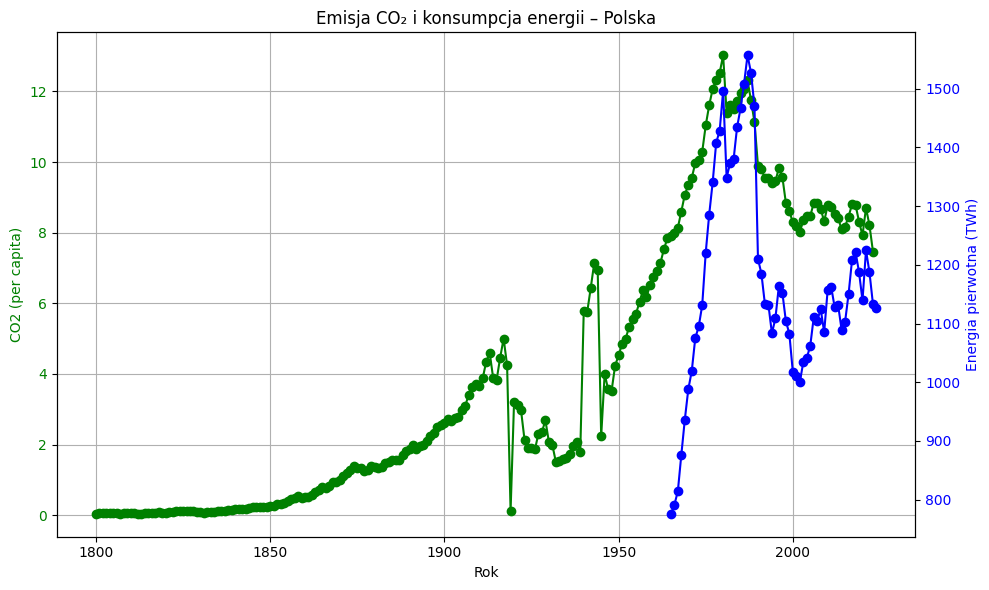

In [16]:
selected_country = "Poland"
df_country = df[df["country"] == selected_country]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(
    df_country["year"],
    df_country["co2"],
    color="green",
    marker="o",
    label="CO2"
)
ax1.set_xlabel("Rok")
ax1.set_ylabel("CO2 (per capita)", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(
    df_country["year"],
    df_country["energy"],
    color="blue",
    marker="o",
    label="Energy"
)
ax2.set_ylabel("Energia pierwotna (TWh)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("Emisja CO₂ i konsumpcja energii – Polska")
fig.tight_layout()
plt.show()